In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import warnings
import preprocessing
import model
import evaluation
import pair_selection

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
without = pd.read_csv("data/withoutsolar_ori.csv")
withsolar = pd.read_csv("data/withsolar_ori.csv")

customer_id = 661
data = pd.read_csv(f"data/user_{customer_id}_15min.csv")
data["solar"]=data["solar"].apply(lambda x:max(0,x))

# Select a group of non-solar customers whose load consumption behaviors are most similar to a given solar customer.

In [3]:
# Select customers with no missing data
solar_irradiance = data["GHI"]
without = without[
    without["dataid"].groupby(without["dataid"]).transform("size") == 2688
]
withsolar = withsolar[
    withsolar["dataid"].groupby(withsolar["dataid"]).transform("size") == 2688
]

In [4]:
withsolar["GHI"] = len(withsolar.dataid.unique()) * list(solar_irradiance)
without["GHI"] = len(without.dataid.unique()) * list(solar_irradiance)

In [5]:
# Extract dayofyear, timeofday and minute information from the timestamp
without["dayofyear"] = without["local_15min"].apply(
    lambda x: pd.to_datetime(x).timetuple().tm_yday
)
without["timeofday"] = [int(x[11:13]) for x in without["local_15min"]]
without["minute"] = [int(x[14:16]) for x in without["local_15min"]]

withsolar["dayofyear"] = withsolar["local_15min"].apply(
    lambda x: pd.to_datetime(x).timetuple().tm_yday
)
withsolar["timeofday"] = [int(x[11:13]) for x in withsolar["local_15min"]]
withsolar["minute"] = [int(x[14:16]) for x in withsolar["local_15min"]]

In [6]:
# Select time slots which are 1) in the daytime 2) with low solar irradiance
candidates = data.loc[
    (data["timeofday"] >= 8) & (data["timeofday"] <= 18) & (data["GHI"] <= 20)
].index

In [7]:
# Collect grid data from solar customers in those low-irradiance time slots
dic_solar = collections.defaultdict(list)
for id in withsolar.dataid.unique():
    low_irradiance = withsolar[withsolar["dataid"] == id]
    for index in candidates:
        dic_solar[id].append(low_irradiance.iloc[index]["grid"])

In [8]:
# Collect grid data from non-solar customers in those low-irradiance time slots
dic_without = collections.defaultdict(list)
for id in without.dataid.unique():
    low_irradiance = without[without["dataid"] == id]
    for index in candidates:
        dic_without[id].append(low_irradiance.iloc[index]["use"])

In [9]:
# Calculate the squared Euclidean distance between solar customers and non-solar customers
dic = collections.defaultdict(list)
for key1 in dic_solar:
    for key2 in dic_without:
        ss = sum((i - j) ** 2 for i, j in zip(dic_solar[key1], dic_without[key2]))
        dic[key1].append([key2, ss])

In [10]:
dic_select = collections.defaultdict(list)
for key in dic:
    dic[key].sort(key=lambda x: x[1])
    cnt = 0
    while cnt < 20:
        dic_select[key].append(dic[key][cnt][0])
        cnt += 1

similar_customer_group = pd.DataFrame(dic_select.items())

# Solar disaggregation for individual customer

In [11]:
# Enter the approximate latitude and lontitude
latitude = 30.29
longitude = -97.69

In [12]:
if torch.cuda.is_available():
    print(f"Deploying GPU.")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. CPU will be deployed.")
    device = None

Deploying GPU.


In [13]:
# Preprocess data
data = preprocessing.data_preprocessing(data, longitude, latitude)

In [14]:
data_daytime = data.loc[(data["timeofday"] >= 8) & (data["timeofday"] <= 18)]
data_daytime["minuteofyear"] = data_daytime["timeofday"] * 60 + data_daytime["minute"]
data_daytime.reset_index(drop=True, inplace=True)

# Construct a aggregated non_solar customer load profile (aggregation of similar nonsolar customers of the given solar customer)
similar_customer_group.columns = ["id", "group"]
index = similar_customer_group[similar_customer_group["id"] == customer_id].group.index[
    0
]
candidate = similar_customer_group[similar_customer_group["id"] == customer_id].group[
    index
]
without = without.loc[without["dataid"].isin(candidate)]
without = without.loc[(without["timeofday"] >= 8) & (without["timeofday"] <= 18)]
without = without[["dayofyear", "timeofday", "minute", "use"]]
withoutsolar = without.groupby(
    ["dayofyear", "timeofday", "minute"], as_index=False
).mean()
withoutsolar.rename(columns={"use": "ave"}, inplace=True)
withoutsolar["consumption"] = np.array(
    without.groupby(["dayofyear", "timeofday", "minute"]).sum()["use"]
)
irradiance_info = data_daytime[
    ["dayofyear", "timeofday", "minute", "DHI", "DNI", "GHI"]
]
withoutsolar = pd.merge(
    withoutsolar, irradiance_info, how="right", on=["dayofyear", "timeofday", "minute"]
)
withoutsolar["minuteofday"] = withoutsolar["timeofday"] * 60 + withoutsolar["minute"]
withoutsolar.reset_index(drop=True, inplace=True)

withoutsolar = withoutsolar.sort_values("consumption", ascending=False)

D:\Anaconda\Package\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
withoutsolar.head()

,dayofyear,timeofday,minute,ave,consumption,DHI,DNI,GHI,minuteofday
437,285,18,15,2.519437,50.388733,52.5,315.0,109.5,1095
433,285,17,15,2.478687,49.573733,93.5,579.5,309.5,1035
435,285,17,45,2.431770,48.635400,76.5,471.5,207.0,1065
438,285,18,30,2.411327,48.226533,38.0,224.0,63.0,1110
381,284,15,15,2.392457,47.849133,126.5,800.5,673.5,915


In [16]:
def transform(y):
    repeat = []
    for i in range(len(y) // 2):
        repeat.append(torch.mean(y[i * 2 : (i + 1) * 2]))
    return torch.repeat_interleave(torch.stack(repeat), repeats=2, dim=0).reshape(
        len(y), 1
    )


def neg_corr(x):
    loss3 = torch.tensor(0.0).to(device)
    x = torch.squeeze(x)
    for k in range(x.shape[0]):
        if x[k] > 0:
            continue
        else:
            loss3 += x[k] ** 2
    return loss3

In [17]:
# Select training time pairs and construct the training set
target_pair_number = 250
p = pair_selection.Helper(withoutsolar)
visited = p.pair_selection(data_daytime, withoutsolar, target_pair_number, "individual")
df_training = p.training_data_constuct(data_daytime, withoutsolar)

train_data = torch.tensor(np.array(df_training, dtype=float)).to(device)
true_solar = torch.tensor(np.array(df_training.solar, dtype=float)).to(device)
train_net = torch.tensor(np.array(df_training.grid, dtype=float)).to(device)
train_net = train_net.reshape(train_net.shape[0], -1).to(device)

In [18]:
# Training
model_train = model.PhysicalModel(latitude).to(device)
criterion = nn.MSELoss()

withoutsolar = withoutsolar.sort_values(["dayofyear", "timeofday", "minute"])
data_total = torch.tensor(np.array(data_daytime)).to(device)

train_grid = torch.tensor(np.array(data_daytime.grid, dtype=float)).to(device)
train_grid = train_grid.reshape(train_grid.shape[0], -1).to(device)

average = torch.tensor(list(withoutsolar["ave"])).to(device)
average = average.reshape(len(average), -1)

learningRate = 0.05
epochs = 2000
optimizer = torch.optim.Adam(model_train.parameters(), lr=learningRate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.7)

model_train.lower, model_train.upper = 0.087, 0.87

for epoch in range(epochs):

    length = len(train_data)
    y = model_train(train_data).reshape(length, 1)
    y2 = model_train(data_total).reshape(len(data_total), -1)
    y2_predict = y2 + train_grid
    y_predict = y + train_net
    ave = transform(y_predict)
    loss = (
        sum((ave.float() - y_predict.float()) ** 2)
        + sum((model_train.alpha * average.float() - y2_predict.float()) ** 2) * 0.05
        + neg_corr(y2_predict) * 2
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    model_train.beta.data = torch.clip(
        model_train.beta.data, model_train.lower, model_train.upper
    )
    model_train.gamma.data = torch.clip(model_train.gamma.data, 0, 3.1416 * 2)
    model_train.capacity.data = torch.clip(model_train.capacity.data, 0, 1000)
    if epoch % 200 == 0:
        print(f"Training Epochs: {epoch} Training Loss: {loss.item()}")

Training Epochs: 0 Training Loss: 8264.609375
Training Epochs: 200 Training Loss: 216.19186401367188
Training Epochs: 400 Training Loss: 165.5181121826172
Training Epochs: 600 Training Loss: 158.88929748535156
Training Epochs: 800 Training Loss: 156.18861389160156
Training Epochs: 1000 Training Loss: 154.75001525878906
Training Epochs: 1200 Training Loss: 153.88775634765625
Training Epochs: 1400 Training Loss: 153.3358612060547
Training Epochs: 1600 Training Loss: 152.96603393554688
Training Epochs: 1800 Training Loss: 152.70875549316406


In [19]:
# Post disaggregation correction: predicted load should always be positive
data_total = torch.tensor(np.array(data)).to(device)
data["prediction"] = model_train(data_total).cpu().detach().numpy()
data["prediction"] = data["prediction"].apply(lambda x: max(0, x))

col = "prediction"
solar_corr = []
for i in range(len(data)):
    if data.iloc[i][col] + data.iloc[i]["grid"] < 0:
        solar_corr.append(-data.iloc[i]["grid"])
    else:
        solar_corr.append(data.iloc[i][col])

data["prediction"] = solar_corr

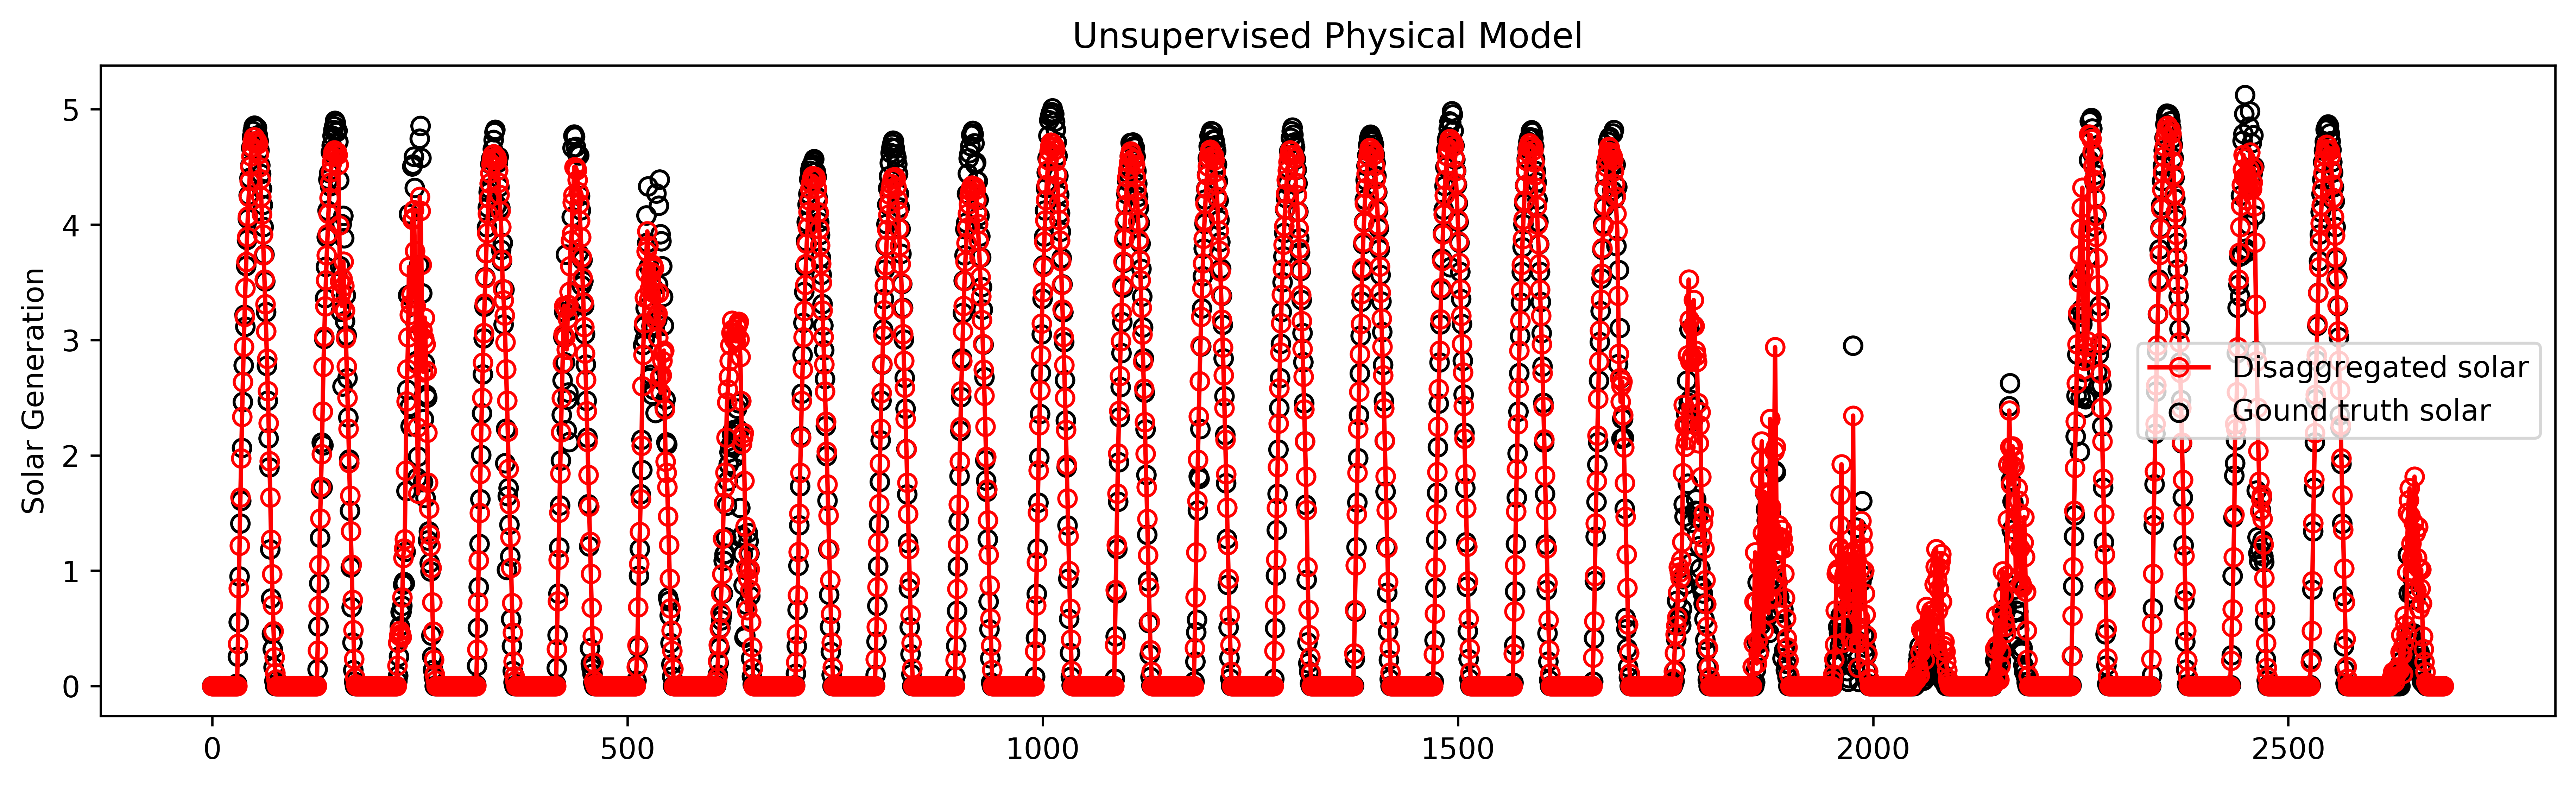

In [20]:
data = data.sort_values(["dayofyear", "timeofday"])
fig = plt.figure(figsize=(15, 4), dpi=600)
plt.scatter(range(len(data)), data.solar, marker="o", c="", edgecolors="black")
plt.plot(
    range(len(data)), data.prediction, marker="o", color="red", markerfacecolor="none"
)
plt.ylabel("Solar Generation")
plt.title("Unsupervised Physical Model")
plt.legend(["Disaggregated solar", "Gound truth solar"])
plt.show()

In [21]:
# Evaluation the performance of this unsupervised model (on individual customer)
MSE, MASE, CV = evaluation.model_evaluation(data)
MSE, MASE, CV

(array([0.08225442]), array([1.15529831]), array([0.26401653]))